# Training the PID with LSTM
The data from 01Generate_PID.ipynb is used to train an LSTM network. This model uses the previous 15 seconds of sensor data from the PID controller run and uses it to emulate the heater output that the PID controller would use. The model is saved for use in other notebooks.

Notable features:
* The hyperparameters used to train the model (layers, dropout, batch size, units, and window size) are not necessarily optimal. However, later notebooks indicate that the model developed emulates the behavior of the PID controller well (future work could optimize these for an even better emulation).
* Feature selection with SelectKBest method (https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection) indicates that the only features necessary for good model development are the setpoint and error. The actual temperature value does not directly contribute to a better model. Additional features could in theory be derived and tested.
* Due to the stochastic nature of model training, the model can change slightly with each time it's trained. 
* To avoid overfitting, the model stops training after the validation set loss value does not improve for 25 epochs.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

# For scaling, feature selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split 

# For LSTM model
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback
from keras.models import load_model

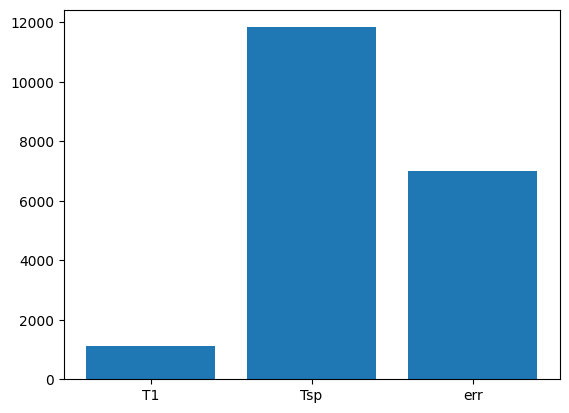

In [18]:
# Load training data
df = pd.read_csv('PID_train_data.csv')

# Create new feature: setpoint error
df['err'] = df['Tsp'] - df['T1']

# Load possible features
X = df[['T1','Tsp','err']]
y = np.ravel(df[['Q1']])

# SelectKBest feature selection
bestfeatures = SelectKBest(score_func=f_regression, k='all')
fit = bestfeatures.fit(X,y)
plt.bar(x=X.columns,height=fit.scores_);

In [19]:
# Hyperparameters for model
window = 15
layers = 2
batch_size = 100
drop = 0.1
units = 100

In [20]:
X = df[['Tsp','err']].values
y = df[['Q1']].values

# Scale data
s_x = MinMaxScaler()
Xs = s_x.fit_transform(X)

s_y = MinMaxScaler()
ys = s_y.fit_transform(y)

# Each input uses last 'window' number of Tsp and err to predict the next Q1
X_lstm = []
y_lstm = []
for i in range(window,len(df)):
    X_lstm.append(Xs[i-window:i])
    y_lstm.append(ys[i])

# Reshape data to format accepted by LSTM
X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

# Split into train and test 
Xtrain, Xtest, ytrain, ytest = train_test_split(X_lstm,y_lstm,test_size=0.2,shuffle=False)

0epoch [00:00, ?epoch/s]
  0%|                                                                                                               | 0/350 [00:00<?, ?epoch/s]
  0%|                                                                                                           | 0.00/35.0 [00:00<?, ?batch/s]
  3%|██▌                                                                                      | 1.00/35.0 [00:02<01:17, 2.28s/batch, loss=0.41]
 17%|███████████████                                                                         | 6.00/35.0 [00:02<00:08, 3.34batch/s, loss=0.146]
 31%|███████████████████████████▋                                                            | 11.0/35.0 [00:02<00:03, 6.87batch/s, loss=0.102]
 46%|███████████████████████████████████████▊                                               | 16.0/35.0 [00:02<00:01, 11.0batch/s, loss=0.0822]
 60%|████████████████████████████████████████████████████▏                                  | 21.0/35.0 [00:02<

 57%|█████████████████████████████████████████████████▏                                    | 20.0/35.0 [00:00<00:00, 41.6batch/s, loss=0.00668]
 71%|█████████████████████████████████████████████████████████████▍                        | 25.0/35.0 [00:00<00:00, 41.3batch/s, loss=0.00671]
 86%|█████████████████████████████████████████████████████████████████████████▋            | 30.0/35.0 [00:00<00:00, 41.1batch/s, loss=0.00709]
  4%|██▉                                                                     | 14/350 [00:15<05:09,  1.09epoch/s, loss=0.0069, val_loss=0.0082]
  0%|                                                                                              | 0.00/35.0 [00:00<?, ?batch/s, loss=0.0069]
 14%|████████████▎                                                                         | 5.00/35.0 [00:00<00:00, 40.4batch/s, loss=0.00631]
 29%|████████████████████████▌                                                             | 10.0/35.0 [00:00<00:00, 40.8batch/s, loss=0

 29%|████████████████████████▌                                                             | 10.0/35.0 [00:00<00:00, 41.0batch/s, loss=0.00484]
 43%|████████████████████████████████████▊                                                 | 15.0/35.0 [00:00<00:00, 40.9batch/s, loss=0.00429]
 57%|█████████████████████████████████████████████████▏                                    | 20.0/35.0 [00:00<00:00, 41.0batch/s, loss=0.00426]
 71%|█████████████████████████████████████████████████████████████▍                        | 25.0/35.0 [00:00<00:00, 41.0batch/s, loss=0.00402]
 86%|█████████████████████████████████████████████████████████████████████████▋            | 30.0/35.0 [00:00<00:00, 41.0batch/s, loss=0.00402]
  8%|█████▌                                                                | 28/350 [00:28<04:57,  1.08epoch/s, loss=0.00409, val_loss=0.00471]
  0%|                                                                                             | 0.00/35.0 [00:00<?, ?batch/s, loss=0

  0%|                                                                                             | 0.00/35.0 [00:00<?, ?batch/s, loss=0.00325]
 14%|████████████▎                                                                         | 5.00/35.0 [00:00<00:00, 42.6batch/s, loss=0.00404]
 29%|████████████████████████▌                                                             | 10.0/35.0 [00:00<00:00, 42.5batch/s, loss=0.00384]
 43%|████████████████████████████████████▊                                                 | 15.0/35.0 [00:00<00:00, 42.2batch/s, loss=0.00339]
 57%|█████████████████████████████████████████████████▏                                    | 20.0/35.0 [00:00<00:00, 41.9batch/s, loss=0.00319]
 71%|█████████████████████████████████████████████████████████████▍                        | 25.0/35.0 [00:00<00:00, 41.5batch/s, loss=0.00322]
 86%|█████████████████████████████████████████████████████████████████████████▋            | 30.0/35.0 [00:00<00:00, 41.1batch/s, loss=0

 86%|█████████████████████████████████████████████████████████████████████████▋            | 30.0/35.0 [00:00<00:00, 40.8batch/s, loss=0.00278]
 16%|███████████                                                           | 55/350 [00:53<04:31,  1.09epoch/s, loss=0.00272, val_loss=0.00275]
  0%|                                                                                             | 0.00/35.0 [00:00<?, ?batch/s, loss=0.00272]
 14%|████████████▎                                                                         | 5.00/35.0 [00:00<00:00, 40.4batch/s, loss=0.00219]
 29%|████████████████████████▌                                                             | 10.0/35.0 [00:00<00:00, 40.2batch/s, loss=0.00293]
 43%|████████████████████████████████████▊                                                 | 15.0/35.0 [00:00<00:00, 40.3batch/s, loss=0.00261]
 57%|█████████████████████████████████████████████████▏                                    | 20.0/35.0 [00:00<00:00, 40.5batch/s, loss=0

 57%|█████████████████████████████████████████████████▏                                    | 20.0/35.0 [00:00<00:00, 42.1batch/s, loss=0.00227]
 71%|██████████████████████████████████████████████████████████████▏                        | 25.0/35.0 [00:00<00:00, 42.1batch/s, loss=0.0025]
 86%|█████████████████████████████████████████████████████████████████████████▋            | 30.0/35.0 [00:00<00:00, 42.0batch/s, loss=0.00232]
 20%|█████████████▊                                                        | 69/350 [01:06<04:13,  1.11epoch/s, loss=0.00228, val_loss=0.00272]
  0%|                                                                                             | 0.00/35.0 [00:00<?, ?batch/s, loss=0.00228]
 14%|████████████▏                                                                        | 5.00/35.0 [00:00<00:00, 41.8batch/s, loss=0.000944]
 29%|████████████████████████▌                                                             | 10.0/35.0 [00:00<00:00, 41.8batch/s, loss=0

 29%|████████████████████████▌                                                             | 10.0/35.0 [00:00<00:00, 41.0batch/s, loss=0.00231]
 43%|████████████████████████████████████▊                                                 | 15.0/35.0 [00:00<00:00, 41.1batch/s, loss=0.00193]
 57%|█████████████████████████████████████████████████▋                                     | 20.0/35.0 [00:00<00:00, 41.5batch/s, loss=0.0022]
 71%|█████████████████████████████████████████████████████████████▍                        | 25.0/35.0 [00:00<00:00, 41.6batch/s, loss=0.00234]
 86%|█████████████████████████████████████████████████████████████████████████▋            | 30.0/35.0 [00:00<00:00, 41.8batch/s, loss=0.00211]
 24%|████████████████▌                                                     | 83/350 [01:18<04:01,  1.11epoch/s, loss=0.00215, val_loss=0.00213]
  0%|                                                                                             | 0.00/35.0 [00:00<?, ?batch/s, loss=0

  0%|                                                                                               | 0.00/35.0 [00:00<?, ?batch/s, loss=0.002]
 14%|████████████▎                                                                         | 5.00/35.0 [00:00<00:00, 40.8batch/s, loss=0.00299]
 29%|████████████████████████▌                                                             | 10.0/35.0 [00:00<00:00, 41.0batch/s, loss=0.00317]
 43%|████████████████████████████████████▊                                                 | 15.0/35.0 [00:00<00:00, 40.9batch/s, loss=0.00252]
 57%|█████████████████████████████████████████████████▏                                    | 20.0/35.0 [00:00<00:00, 40.7batch/s, loss=0.00211]
 71%|█████████████████████████████████████████████████████████████▍                        | 25.0/35.0 [00:00<00:00, 40.6batch/s, loss=0.00217]
 86%|█████████████████████████████████████████████████████████████████████████▋            | 30.0/35.0 [00:00<00:00, 40.7batch/s, loss=0

 69%|██████████████████████████████████████████████████████████▉                           | 24.0/35.0 [00:00<00:00, 38.5batch/s, loss=0.00162]
 80%|████████████████████████████████████████████████████████████████████▊                 | 28.0/35.0 [00:00<00:00, 38.4batch/s, loss=0.00178]
 31%|█████████████████████▋                                               | 110/350 [01:43<03:47,  1.06epoch/s, loss=0.00188, val_loss=0.00215]
  0%|                                                                                             | 0.00/35.0 [00:00<?, ?batch/s, loss=0.00188]
 11%|█████████▊                                                                            | 4.00/35.0 [00:00<00:00, 38.6batch/s, loss=0.00193]
 23%|███████████████████▋                                                                  | 8.00/35.0 [00:00<00:00, 38.5batch/s, loss=0.00161]
 34%|█████████████████████████████▍                                                        | 12.0/35.0 [00:00<00:00, 38.4batch/s, loss=0

 23%|███████████████████▉                                                                   | 8.00/35.0 [00:00<00:00, 38.7batch/s, loss=0.0015]
 34%|█████████████████████████████▍                                                        | 12.0/35.0 [00:00<00:00, 38.6batch/s, loss=0.00123]
 46%|███████████████████████████████████████▎                                              | 16.0/35.0 [00:00<00:00, 38.5batch/s, loss=0.00149]
 57%|█████████████████████████████████████████████████▏                                    | 20.0/35.0 [00:00<00:00, 38.5batch/s, loss=0.00133]
 69%|██████████████████████████████████████████████████████████▉                           | 24.0/35.0 [00:00<00:00, 38.5batch/s, loss=0.00158]
 80%|████████████████████████████████████████████████████████████████████▊                 | 28.0/35.0 [00:00<00:00, 38.4batch/s, loss=0.00158]
 35%|████████████████████████▏                                            | 123/350 [01:56<03:42,  1.02epoch/s, loss=0.00193, val_loss=0

 46%|███████████████████████████████████████▊                                               | 16.0/35.0 [00:00<00:00, 38.4batch/s, loss=0.0007]
 57%|█████████████████████████████████████████████████▏                                    | 20.0/35.0 [00:00<00:00, 38.5batch/s, loss=0.00175]
 69%|███████████████████████████████████████████████████████████▋                           | 24.0/35.0 [00:00<00:00, 38.4batch/s, loss=0.0019]
 80%|████████████████████████████████████████████████████████████████████▊                 | 28.0/35.0 [00:00<00:00, 38.3batch/s, loss=0.00193]
 39%|██████████████████████████▌                                          | 135/350 [02:07<03:30,  1.02epoch/s, loss=0.00188, val_loss=0.00182]
  0%|                                                                                             | 0.00/35.0 [00:00<?, ?batch/s, loss=0.00188]
 11%|█████████▊                                                                            | 4.00/35.0 [00:00<00:00, 39.7batch/s, loss=0

 14%|████████████▎                                                                         | 5.00/35.0 [00:00<00:00, 40.8batch/s, loss=0.00188]
 29%|████████████████████████▌                                                             | 10.0/35.0 [00:00<00:00, 40.2batch/s, loss=0.00177]
 43%|████████████████████████████████████▊                                                 | 15.0/35.0 [00:00<00:00, 39.9batch/s, loss=0.00188]
 54%|██████████████████████████████████████████████▋                                       | 19.0/35.0 [00:00<00:00, 39.8batch/s, loss=0.00192]
 66%|████████████████████████████████████████████████████████▌                             | 23.0/35.0 [00:00<00:00, 39.6batch/s, loss=0.00174]
 77%|██████████████████████████████████████████████████████████████████▎                   | 27.0/35.0 [00:00<00:00, 39.6batch/s, loss=0.00159]
 42%|█████████████████████████████▏                                       | 148/350 [02:20<03:11,  1.05epoch/s, loss=0.00168, val_loss=0

 86%|█████████████████████████████████████████████████████████████████████████▋            | 30.0/35.0 [00:00<00:00, 40.2batch/s, loss=0.00153]
 46%|███████████████████████████████▋                                     | 161/350 [02:32<02:56,  1.07epoch/s, loss=0.00159, val_loss=0.00216]
  0%|                                                                                             | 0.00/35.0 [00:00<?, ?batch/s, loss=0.00159]
 14%|████████████▏                                                                        | 5.00/35.0 [00:00<00:00, 39.5batch/s, loss=0.000605]
 26%|██████████████████████                                                                | 9.00/35.0 [00:00<00:00, 38.7batch/s, loss=0.00182]
 37%|███████████████████████████████▉                                                      | 13.0/35.0 [00:00<00:00, 38.5batch/s, loss=0.00146]
 49%|█████████████████████████████████████████▊                                            | 17.0/35.0 [00:00<00:00, 38.4batch/s, loss=0

 29%|████████████████████████▌                                                             | 10.0/35.0 [00:00<00:00, 39.7batch/s, loss=0.00103]
 40%|██████████████████████████████████▍                                                   | 14.0/35.0 [00:00<00:00, 39.6batch/s, loss=0.00101]
 51%|████████████████████████████████████████████▏                                         | 18.0/35.0 [00:00<00:00, 39.6batch/s, loss=0.00118]
 63%|██████████████████████████████████████████████████████                                | 22.0/35.0 [00:00<00:00, 39.4batch/s, loss=0.00106]
 74%|███████████████████████████████████████████████████████████████▉                      | 26.0/35.0 [00:00<00:00, 39.5batch/s, loss=0.00154]
 86%|█████████████████████████████████████████████████████████████████████████▋            | 30.0/35.0 [00:00<00:00, 39.6batch/s, loss=0.00164]
 50%|██████████████████████████████████▎                                  | 174/350 [02:44<02:47,  1.05epoch/s, loss=0.00158, val_loss=0

 57%|█████████████████████████████████████████████████▏                                    | 20.0/35.0 [00:00<00:00, 39.9batch/s, loss=0.00109]
 71%|█████████████████████████████████████████████████████████████▍                        | 25.0/35.0 [00:00<00:00, 40.2batch/s, loss=0.00135]
 86%|█████████████████████████████████████████████████████████████████████████▋            | 30.0/35.0 [00:00<00:00, 40.2batch/s, loss=0.00134]
 53%|████████████████████████████████████▋                                | 186/350 [02:56<02:39,  1.03epoch/s, loss=0.00165, val_loss=0.00178]
  0%|                                                                                             | 0.00/35.0 [00:00<?, ?batch/s, loss=0.00165]
 14%|████████████▎                                                                         | 5.00/35.0 [00:00<00:00, 40.4batch/s, loss=0.00159]
 29%|████████████████████████▊                                                              | 10.0/35.0 [00:00<00:00, 40.7batch/s, loss=

Epoch 191: early stopping



 55%|█████████████████████████████████████▋                               | 191/350 [03:01<02:30,  1.05epoch/s, loss=0.00168, val_loss=0.00241]
d:\projects\jupyternotebook\pidtolstm\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


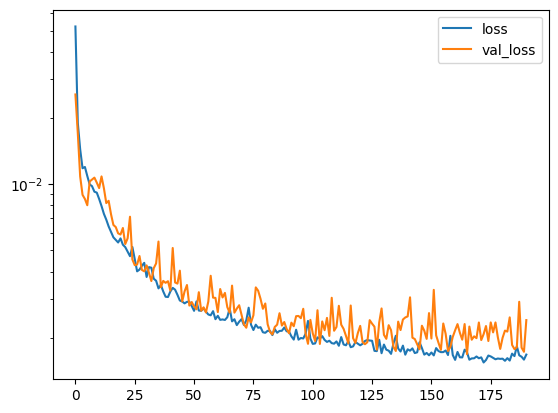

In [21]:
# Keras LSTM model
model = Sequential()

if layers == 1:
    model.add(LSTM(units=units, 
                   input_shape=(Xtrain.shape[1],Xtrain.shape[2])
                  )
             )
    model.add(Dropout(rate=drop))
else:
    # First layer specifies input_shape and returns sequences
    model.add(LSTM(units=units, 
                   return_sequences=True, 
                   input_shape=(Xtrain.shape[1],Xtrain.shape[2])
                  )
             )
    model.add(Dropout(rate=drop))
    # Middle layers return sequences
    for i in range(layers-2):
        model.add(LSTM(units=units,return_sequences=True))
        model.add(Dropout(rate=drop))
    # Last layer doesn't return anything
    model.add(LSTM(units=units))
    model.add(Dropout(rate=drop))

model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=25
                  )

result = model.fit(Xtrain, ytrain, 
                   verbose=0, 
                   validation_split=0.2,
                   callbacks = [es,TqdmCallback(verbose=1)],
                   batch_size=batch_size,
                   epochs=350)

# Show results and save
epochs = es.stopped_epoch
plt.semilogy(result.history['loss'],label='loss')
plt.semilogy(result.history['val_loss'],label='val_loss')
plt.legend()

model.save('pid_emulate.h5')

In [24]:
# Save model parameters
model_params = dict()
model_params['Xscale'] = s_x
model_params['yscale'] = s_y
model_params['window'] = window

pickle.dump(model_params, open('model_params.pkl', 'wb'))

34/34 [==============================] - 0s 3ms/step


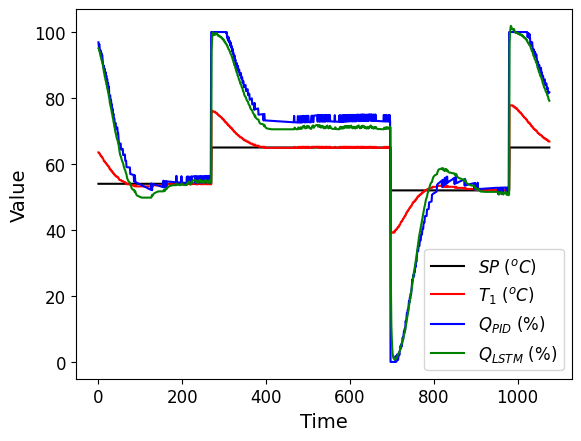

In [25]:
# Predict using LSTM
yp_s = model.predict(Xtest)

# Unscale data
Xtest_us = s_x.inverse_transform(Xtest[:,-1,:])
ytest_us = s_y.inverse_transform(ytest)
yp = s_y.inverse_transform(yp_s)

# Derive Tsp (setpoint) and T1 (sensor) from X data
sp = Xtest_us[:,0]
pv = Xtest_us[:,0] + Xtest_us[:,1]

# Plot SP, PID response, and LSTM response
plt.plot(sp,'k-',label='$SP$ $(^oC)$')
plt.plot(pv,'r-',label='$T_1$ $(^oC)$')
plt.plot(ytest_us,'b-',label='$Q_{PID}$ (%)')
plt.plot(yp,'g-',label='$Q_{LSTM}$ (%)')
plt.legend(fontsize=12,loc='lower right')
plt.xlabel('Time',size=14)
plt.ylabel('Value',size=14)
plt.xticks(size=12)
plt.yticks(size=12);